In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)

In [2]:
with open('data/daily_dialogue_annotated.json', 'r', encoding="utf8") as f:
    daily = json.load(f)

In [3]:
with open('data/topical_chat_annotated.json', 'r', encoding="utf8") as f:
    topical = json.load(f)

In [4]:
len(daily), len(topical)

(12376, 8628)

In [5]:
tmp_daily, tmp_topical = dict(list(daily.items())[0:1]), dict(list(topical.items())[0:1])

In [6]:
tmp_daily

{'d140f760cbbde8a5e6e16a1b12658ae21677422c': [{'text': ['Wow!',
    'Your fruit looks really fresh!',
    'How much are these apples?'],
   'midas': [[{'appreciation': 0.31727999448776245,
      'command': 0.02779145911335945,
      'comment': 0.37704598903656006,
      'complaint': 0.08285180479288101,
      'dev_command': 0.03407049551606178,
      'neg_answer': 0.007693831343203783,
      'open_question_factual': 0.009812155738472939,
      'open_question_opinion': 0.011604975908994675,
      'opinion': 0.0780458152294159,
      'other_answers': 0.004871767479926348,
      'pos_answer': 0.013889022171497345,
      'statement': 0.023184802383184433,
      'yes_no_question': 0.011857947334647179}],
    [{'appreciation': 0.12023277580738068,
      'command': 0.027278020977973938,
      'comment': 0.17194725573062897,
      'complaint': 0.037386421114206314,
      'dev_command': 0.027481747791171074,
      'neg_answer': 0.020154708996415138,
      'open_question_factual': 0.029528163373

In [7]:
def parse_ut(ut: dict):
    zero_entity = list()
    one_entity = list()
    
    for sent, midas, entities in zip(ut['text'], ut['midas'], ut['entities']):

        if len(midas) != 1 or len(entities) > 1:
            continue
        
        if len(entities) == 0:
            zero_entity.append({
                'text': sent,
                'midas_label': max(midas[0], key=midas[0].get)
            })
            
        if len(entities) == 1:
            e = entities[0]
            one_entity.append({
            'text': sent[:e['offsets'][0]] + e['label'].upper() + sent[e['offsets'][1]:],
            'midas_label': max(midas[0], key=midas[0].get),
            'entity': e})
        
    return zero_entity, one_entity

def parse_dataset(dataset: dict):
    one_entity_df = list()
    zero_entity_df = list()
    
    for idx, dialogue in dataset.items():
        for ut in dialogue:
            zero_entity, one_entity = parse_ut(ut)
            
            zero_entity_df += zero_entity
            one_entity_df += one_entity
        
    return zero_entity_df, one_entity_df

## Topical

In [8]:
zero_entity_topical, one_entity_topical = parse_dataset(topical)
zero_entity_topical = pd.json_normalize(zero_entity_topical)
one_entity_topical = pd.json_normalize(one_entity_topical)
one_entity_topical.head()

,text,midas_label,entity.label,entity.offsets,entity.text
0,Both are excellent MISC they are helpful in many ways.,opinion,misc,"[19, 29]",technology
1,I'm not a huge fan of ORGANIZATION.,opinion,organization,"[23, 29]",google
2,I think they are a MISC in some sense.,opinion,misc,"[19, 27]",monopoly
3,which includes MISC.,statement,misc,"[15, 25]",online ads
4,I'm just not a fan of MISC they can be on our personal lives.,opinion,misc,"[22, 31]",intrusive


In [9]:
one_freq_topical = one_entity_topical.value_counts(["midas_label", "entity.label"]).reset_index()
one_freq_topical['category'] = one_freq_topical["midas_label"] + "+" + one_freq_topical["entity.label"]
one_freq_topical = one_freq_topical.iloc[:, [3,2,0,1]].rename(columns = {0: "counter"})
one_freq_topical.head()

,category,counter,midas_label,entity.label
0,opinion+misc,59674,opinion,misc
1,statement+misc,35824,statement,misc
2,comment+misc,21179,comment,misc
3,yes_no_question+misc,8205,yes_no_question,misc
4,opinion+person,5323,opinion,person


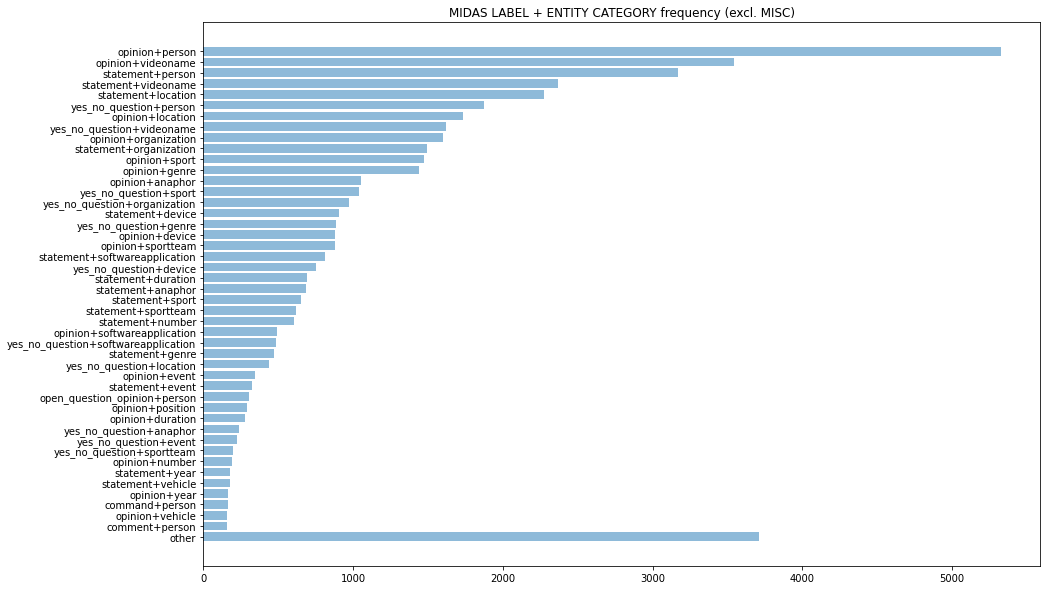

In [10]:
#defining the threshold 
df_topical = one_freq_topical[one_freq_topical['entity.label'] != 'misc'].iloc[:, [0,1]]
threshold = 150
mask = df_topical['counter'] < threshold
df_topical1 = df_topical[~mask].copy()
df_topical1.loc[df_topical.shape[0]+1] = df_topical.loc[mask, 'counter'].sum()

labels_topical = df_topical1.category.tolist()
labels_topical[-1] = 'other'
y_pos_topical = np.arange(len(labels_topical))
counter_topical = df_topical1.counter.tolist()

plt.figure(figsize=(15,10))
plt.barh(y_pos_topical, counter_topical, align='center', alpha=0.5)
plt.yticks(y_pos_topical, labels_topical)
plt.gca().invert_yaxis()
plt.title('MIDAS LABEL + ENTITY CATEGORY frequency (excl. MISC)')
plt.savefig("img/groupings_topical.png")

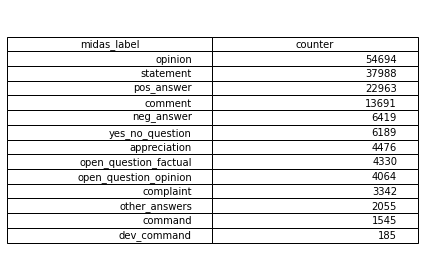

In [12]:
zero_freq_topical = zero_entity_topical.value_counts(["midas_label"]).reset_index().rename(
    columns = {0: "counter"})
fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=zero_freq_topical.values, colLabels=zero_freq_topical.columns, loc='center')
fig.tight_layout()
plt.savefig("img/zero_ent_by_midas_topical.png")

In [14]:
zero_entity_topical[zero_entity_topical.midas_label == 'comment'].head(10)

,text,midas_label
3,It is very interesting.,comment
13,it was nice chatting with you.,comment
18,Yeah they are much smarter than we give them credit for,comment
23,Yeah interesting point.,comment
42,Yes that is amazing.,comment
51,That can't be cheap for them.,comment
86,People say it is a great place to work at though,comment
87,Wow.,comment
88,wow.,comment
98,That was pretty smart of them.,comment


In [15]:
result = one_entity_topical.to_json(orient="records")
parsed = json.loads(result)  

one_entity_topical = {}

for sample in parsed:
    category = sample['midas_label'] + "__" + sample['entity.label']
    
    if category not in one_entity_topical:
        one_entity_topical[category] = [sample['text'].strip()]
    else:
        one_entity_topical[category].append(sample['text'].strip())
        
with open('data/one_entity_topical.json', 'w', encoding='utf-8') as f:
    json.dump(one_entity_topical, f, ensure_ascii=False, indent=4)

In [16]:
result = zero_entity_topical.to_json(orient="records")
parsed = json.loads(result)

zero_entity_topical = {}

for sample in parsed:
    if sample['midas_label'] not in zero_entity_topical:
        zero_entity_topical[sample['midas_label']] = [sample['text'].strip()]
    else:
        zero_entity_topical[sample['midas_label']].append(sample['text'].strip())
        
with open('data/zero_entity_topical.json', 'w', encoding='utf-8') as f:
    json.dump(zero_entity_topical, f, ensure_ascii=False, indent=4)

## Daily

In [17]:
zero_entity_daily, one_entity_daily = parse_dataset(daily)
zero_entity_daily = pd.json_normalize(zero_entity_daily)
one_entity_daily = pd.json_normalize(one_entity_daily)
one_entity_daily.head()

,text,midas_label,entity.label,entity.offsets,entity.text
0,Your MISC looks really fresh!,opinion,misc,"[5, 10]",fruit
1,How much are these MISC?,open_question_factual,misc,"[19, 25]",apples
2,The MISC are 30NT each.,statement,misc,"[4, 10]",apples
3,How about these MISC?,open_question_opinion,misc,"[16, 26]",pineapples
4,They're only used for MISC.,statement,misc,"[22, 29]",worship


In [18]:
one_freq_daily = one_entity_daily.value_counts(["midas_label", "entity.label"]).reset_index()
one_freq_daily['category'] = one_freq_daily["midas_label"] + "+" + one_freq_daily["entity.label"]
one_freq_daily = one_freq_daily.iloc[:, [3,2,0,1]].rename(columns = {0: "counter"})
one_freq_daily.head()

,category,counter,midas_label,entity.label
0,statement+misc,22780,statement,misc
1,opinion+misc,13303,opinion,misc
2,yes_no_question+misc,6026,yes_no_question,misc
3,open_question_factual+misc,3960,open_question_factual,misc
4,command+misc,3421,command,misc


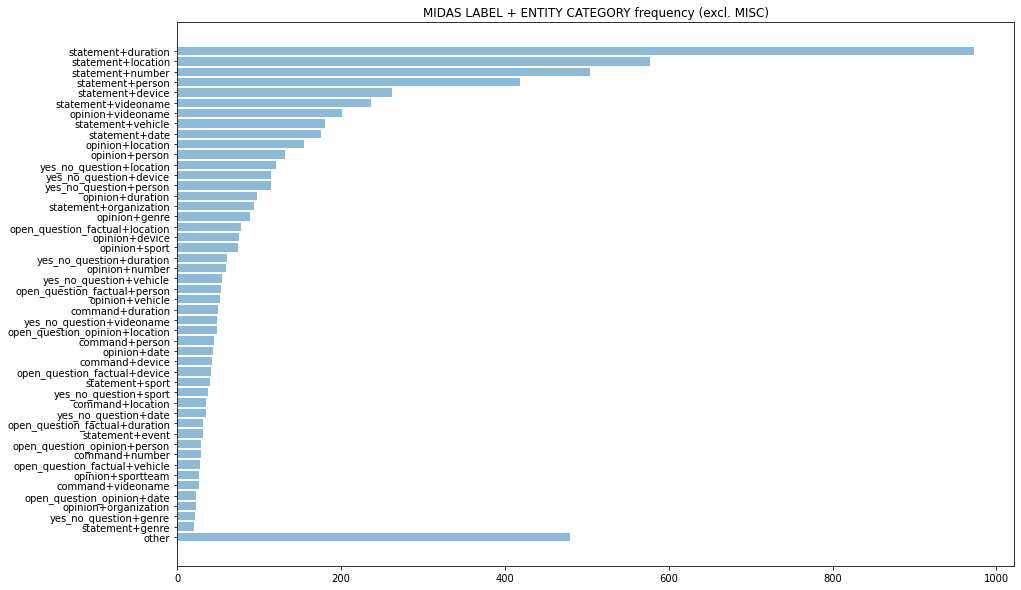

In [19]:
#defining the threshold 
df_daily = one_freq_daily[~one_freq_daily['entity.label'].isin(['misc', 'anaphor'])].iloc[:, [0,1]]
threshold = 20
mask = df_daily['counter'] < threshold
df_daily1 = df_daily[~mask].copy()
df_daily1.loc[df_daily.shape[0]+1] = df_daily.loc[mask, 'counter'].sum()

labels_daily = df_daily1.category.tolist()
labels_daily[-1] = 'other'
y_pos_daily = np.arange(len(labels_daily))
counter_daily = df_daily1.counter.tolist()

plt.figure(figsize=(15,10))
plt.barh(y_pos_daily, counter_daily, align='center', alpha=0.5)
plt.yticks(y_pos_daily, labels_daily)
plt.gca().invert_yaxis()
plt.title('MIDAS LABEL + ENTITY CATEGORY frequency (excl. MISC)')
plt.savefig("img/groupings_daily.png")

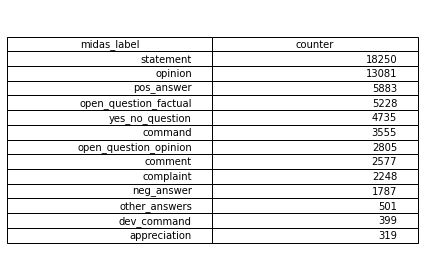

In [20]:
zero_freq_daily = zero_entity_daily.value_counts(["midas_label"]).reset_index().rename(
    columns = {0: "counter"})
fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=zero_freq_daily.values, colLabels=zero_freq_daily.columns, loc='center')
fig.tight_layout()
plt.savefig("img/zero_ent_by_midas_daily.png")

In [21]:
zero_entity_daily[zero_entity_daily.midas_label == 'command'].head(10)

,text,midas_label
32,Please wait a moment and fill out the order form.,command
38,Excuse me.,command
87,"I'm sorry, refresh my mind.",command
93,"Don't forget to perform your duty next time, ok?",command
94,"Now, let's start our lesson.",command
155,Right.,command
169,That's what we want.,command
186,Check with somebody from the IT department.,command
195,Hello?,command
200,Let me call you later.,command


In [22]:
result = one_entity_daily.to_json(orient="records")
parsed = json.loads(result)  

one_entity_daily = {}

for sample in parsed:
    category = sample['midas_label'] + "__" + sample['entity.label']
    
    if category not in one_entity_daily:
        one_entity_daily[category] = [sample['text'].strip()]
    else:
        one_entity_daily[category].append(sample['text'].strip())
        
with open('data/one_entity_daily.json', 'w', encoding='utf-8') as f:
    json.dump(one_entity_daily, f, ensure_ascii=False, indent=4)

In [23]:
result = zero_entity_daily.to_json(orient="records")
parsed = json.loads(result)

zero_entity_daily = {}

for sample in parsed:
    if sample['midas_label'] not in zero_entity_daily:
        zero_entity_daily[sample['midas_label']] = [sample['text'].strip()]
    else:
        zero_entity_daily[sample['midas_label']].append(sample['text'].strip())
        
with open('data/zero_entity_daily.json', 'w', encoding='utf-8') as f:
    json.dump(zero_entity_daily, f, ensure_ascii=False, indent=4)